# Mechano-Informatics Exercise Session 1

Import important environment variables.

In [1]:
from robot_env.control.mi_code_session import *

from IPython.core.magic import register_cell_magic

# create cell magic method to ignore system exits in Mujoco environment
@register_cell_magic('ignore_system_exit')
def handle(line, cell):
    try:
        return exec(cell)
    except SystemExit as exc:
        pass

## 1. Visualize the Robot Simulation Environment

In this code session, we are going to explore the concept and technical implementation about spatial transformation in a robotics context. We will use the humanoid robot ARMAR-6 in the [MuJoCo physics simulation environments](https://mujoco.org/) as shown below.

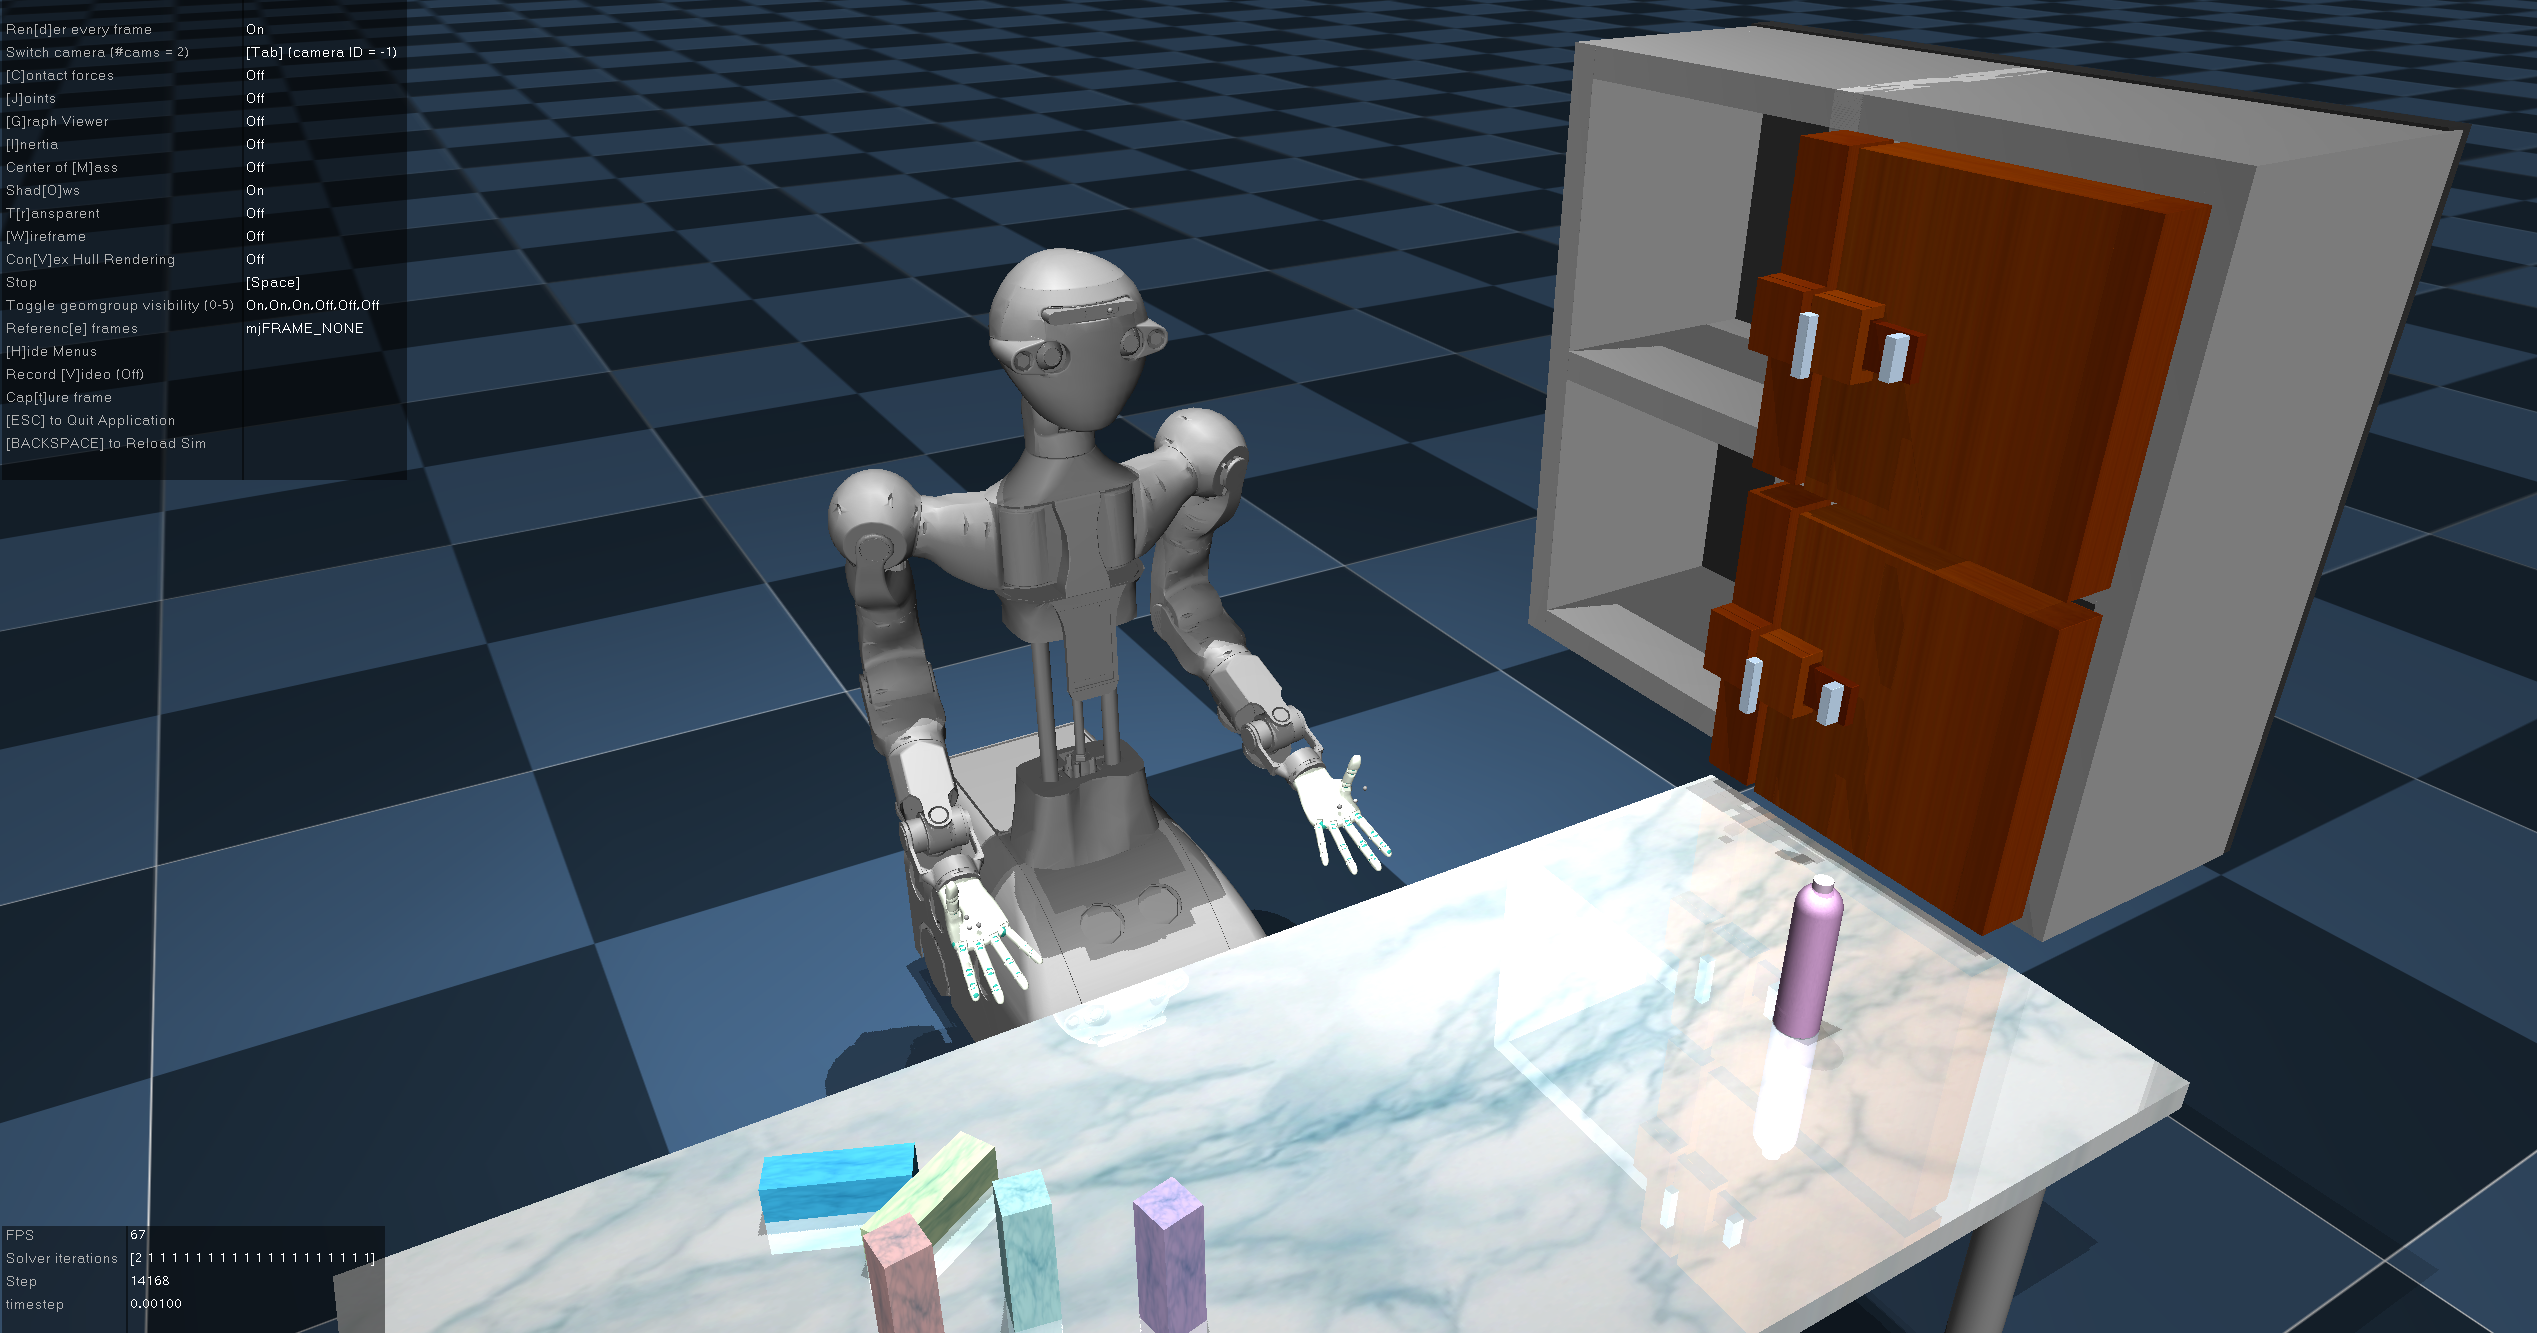

To run the simulation, simply execute the code below. In the GUI, use your mouse to navigate. 

- Mouse wheel to zoom in and out
- Left press and drag to rotate the view
- Right press and drag to translate the view
- Double click a part or an object, it turns whiter. Press ctrl + left button and drag to apply torque. Press ctrl + right button and drag to apply force.
- Other functionalities see top left panel.

In [2]:
%%ignore_system_exit

# We create a simulation environment
robot = Armar6('Armar6BimanualTable-v0')

# This sets the robot to a default (idle) posture
robot.set_navigation_pose()

while True:
    # The robot computes the torque needed to maintain such a posture and the simulation engine renderes the view
    robot.forward()

### 1) Local Frame, Coordinate System

Now, let's visualize some coordinate systems. 

For example, we define a coordinate system at the bottom of the robot, which is rigidly attached to the center of the bottom of the platform. This frame is normally used as a reference to define egocentric spatial representations, such as the pose of the hand.

A pose in cartesian space can be represented by SE(3) group, the Special Euclidean group. It includes the rotation matrix $\mathbf{R}$ and the translation vector $\mathbf{t}$.

$$
\mathbf{T} = \begin{bmatrix} \mathbf{R} & \mathbf{t} \\ \mathbf{0} & 1 \end{bmatrix} \in \mathbb{R}^{3\times 3}
$$

For example, each arm of ARMAR-6 has a coordinate system attached to the Tool Center Point (TCP). In the following simulation interface, it is represented by 3 orthonormal vectors, i.e. $\mathbf{x}, \mathbf{y}, \mathbf{z}$ with red, green, and blue colors, respectively.

<div>
    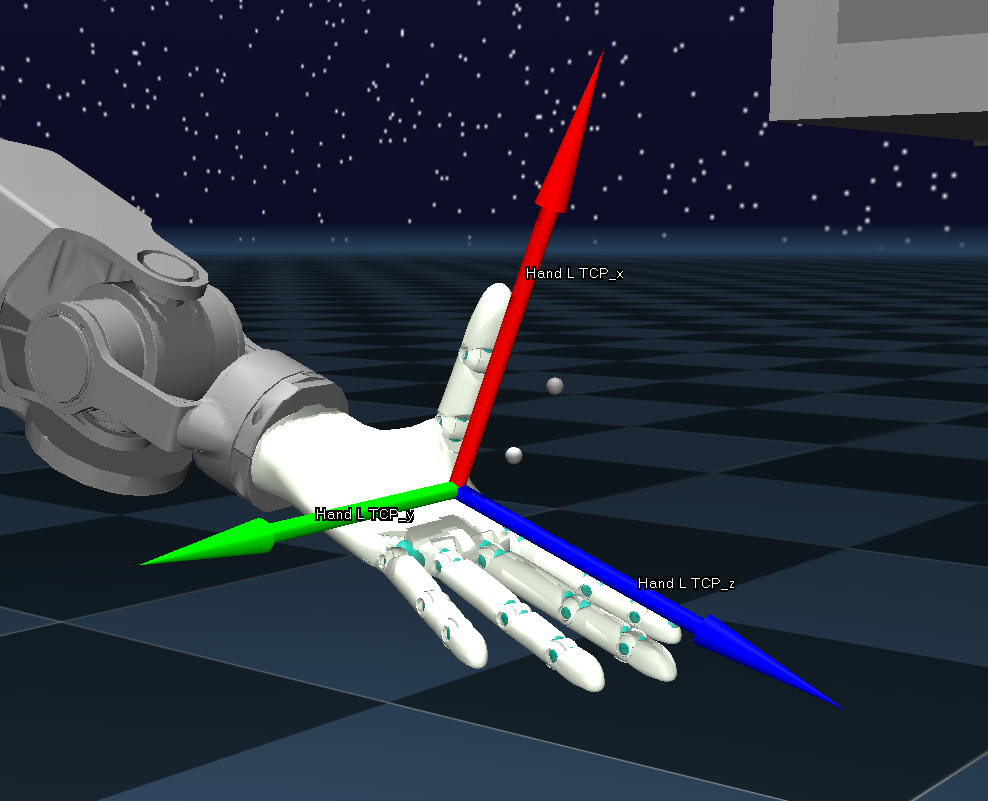
</div>

Rotate the view to see these local frames.

In [3]:
%%ignore_system_exit

robot = Armar6('Armar6BimanualTable-v0')
robot.set_navigation_pose()

while True:
    robot.forward()
    robot.viz_tcp(Armar6NodeSet.LeftArm)
    robot.viz_tcp(Armar6NodeSet.RightArm)
    robot.viz_root()

### 2) TCP Target Pose

We can use a SE(3) transformation matrix to define a target pose of the TCP, which is a local frame represented in the root frame of the robot.

$$
{}^{\text{Root}}\mathbf{T}_{\text{TCP}} = \begin{bmatrix} \mathbf{R} & \mathbf{t} \\ \mathbf{0} & 1 \end{bmatrix} \in \mathbb{R}^{4\times 4}
$$

In the following, we take the left arm as an example, define a target pose, and then control the robot to reach such a target pose.

Let's **define a target pose** in such a way, that 
- the orientation is defined by rotating around `root_x` -90 degrees and
- the position is at (-0.3, 0.7, 1.0). 

In [4]:
# the target orientation as a quaternion
quat_target_l = tn.quaternion_from_euler(-np.pi / 2, 0, 0)
quat_target_l

array([ 0.7071, -0.7071,  0.    ,  0.    ])

This corresponds to the definition of a quaternion as follows,

$$
\mathbf{q} = (w, x, y, z) = \Big (\cos(\dfrac{\phi}{2}), \, \mathbf{a} \sin(\dfrac{\phi}{2}) \Big ) 
$$
where $\mathbf{a}$ corresponds to the rotation axis represented as a unity vector.  

In [5]:
phi = -np.pi / 2
np.cos(phi / 2), np.sin(phi / 2)

(0.7071067811865477, -0.7071067811865476)

In [6]:
# the target orientation as a rotation matrix
xmat_target_l = tn.euler_matrix(-np.pi / 2, 0, 0)[:3, :3]
xmat_target_l


array([[ 1., -0.,  0.],
       [ 0.,  0.,  1.],
       [-0., -1.,  0.]])

In [7]:
# target position
xpos_target_l = np.array([-0.3, 0.7, 1.0])
xpos_target_l

array([-0.3,  0.7,  1. ])

In [8]:
xpose_target_l = np.eye(4, dtype=float)
xpose_target_l[:3, :3] = xmat_target_l
xpose_target_l[:3, 3] = xpos_target_l
xpose_target_l


array([[ 1. , -0. ,  0. , -0.3],
       [ 0. ,  0. ,  1. ,  0.7],
       [-0. , -1. ,  0. ,  1. ],
       [ 0. ,  0. ,  0. ,  1. ]])

Let's visualize the target pose in MuJoCo.

In [9]:
%%ignore_system_exit

robot = Armar6('Armar6BimanualTable-v0')
robot.set_navigation_pose()

while True:
    try:
        robot.forward()
        robot.viz_tcp(Armar6NodeSet.LeftArm)
        robot.viz_tcp(Armar6NodeSet.RightArm)
        robot.viz_root()
        robot.viz_frame_in_root(xmat_target_l, xpos_target_l, scaling=50, label="TCP_L_tgt")
    except:
        break


### 3) Transformation of Position and Vector

Suppose you defined a position relative to the TCP frame, say ${}^{\text{TCP}}\mathbf{p} = (0.2, 0.2, 0.2)$ in meters, as shown below. 


To transform a vector represented in the TCP frame to the root frame, we need to apply SE(3) transformation. 

$$
{}^{\text{Root}}\mathbf{\tilde p} = {}^{\text{Root}}\mathbf{T}_{\text{TCP}} \cdot {}^{\text{TCP}}\mathbf{\tilde p} = \begin{bmatrix} {}^{\text{Root}}\mathbf{R}_{\text{TCP}} & {}^{\text{Root}}\mathbf{t}_{\text{TCP}} \\ \mathbf{0} & 1 \end{bmatrix} \cdot \begin{bmatrix} {}^{\text{TCP}}\mathbf{p} \\ 1 \end{bmatrix}
$$

This is equivalent to
$$
{}^{\text{Root}}\mathbf{p} = {}^{\text{Root}}\mathbf{R}_{\text{TCP}} \cdot {}^{\text{TCP}}\mathbf{p} + {}^{\text{Root}}\mathbf{t}_{\text{TCP}}
$$

In [10]:
robot = Armar6('Armar6BimanualTable-v0')
robot.set_navigation_pose()
tcp_pose = robot.get_tcp_pose(Armar6NodeSet.LeftArm)
root_pose = robot.get_pose("root")
tcp_pose


array([[ 0.005 ,  0.9984, -0.0559, -0.4118],
       [ 0.3675,  0.0502,  0.9287,  0.4249],
       [ 0.93  , -0.0252, -0.3666,  0.7242],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

In [11]:
# expanded equation
point_1_local = np.array([0.2, 0.2, 0.2])
point_1_root = tcp_pose[:3, :3].dot(point_1_local) + tcp_pose[:3, 3]
point_1_root

array([-0.2223,  0.6942,  0.8318])

In [12]:
# homogeneous transformation
point_1_local_homo = np.concatenate((point_1_local, np.array([1])))
point_1_root = tcp_pose.dot(point_1_local_homo)
point_1_root[:3]

array([-0.2223,  0.6942,  0.8318])

In [13]:
%%ignore_system_exit

while True:
    tcp_pose = robot.get_tcp_pose(Armar6NodeSet.LeftArm)

    point_1_local = np.array([0.2, 0.2, 0.2])
    vec_1_local = point_1_local
    point_1_root = tcp_pose[:3, :3].dot(point_1_local) + tcp_pose[:3, 3]
    vec_1_root = tcp_pose[:3, :3].dot(vec_1_local)

    points = {"p1": point_1_root}
    vectors = {
        "v1": (tcp_pose[:3, 3], point_1_root),
        "v2": (root_pose[:3, 3], vec_1_root + tcp_pose[:3, 3])
    }
    
    robot.forward()
    robot.viz_tcp(Armar6NodeSet.LeftArm)
    robot.viz_tcp(Armar6NodeSet.RightArm)
    robot.viz_root()
    for p_name, p in points.items():
        robot.viz_point_in_root(p, size=0.03, label=p_name)
    for v_name, (vs, ve) in vectors.items():
        robot.viz_line_in_root(vs, ve, label=v_name, scale=1, width_in_pixel=4)

In the view, you can see a point `p1` and its position representation relative the TCP local frame and relative to the root frame of the robot. Select the hand and drag it in space to see whether the two vectors change accordingly.

## 2. Quaternion for 3D Rotation

You can look at [this video](https://youtu.be/ACZC_XEyg9U?si=lEAwMWji5ulEdLkq ) to understand the visualization of the Unit Quaternion in 3D space.

Recall that, 

$$
\mathbf{q} = (w, x, y, z) = \Big (\cos(\dfrac{\phi}{2}), \, \mathbf{a} \sin(\dfrac{\phi}{2}) \Big ) 
$$
where $\mathbf{a}$ corresponds to the rotation axis represented as a unity vector.  

When rotating 360 degrees around an axis, we end up in the same orientation again. Let's substitute that into the above equation. 

$$
\mathbf{q}(\phi + 2\pi) = \Big (\cos(\dfrac{\phi + 2\pi}{2}), \, \mathbf{a} \sin(\dfrac{\phi + 2\pi}{2}) \Big ) = 
\Big (\cos(\dfrac{\phi}{2} + \pi), \, \mathbf{a} \sin(\dfrac{\phi}{2} + \pi) \Big ) = \Big (-\cos(\dfrac{\phi}{2}), \, -\mathbf{a} \sin(\dfrac{\phi}{2}) \Big ) = - \mathbf{q}
$$

Therefore, Quaternion space $\mathcal S^3$ is a double coverage of the 3D rotations. In other words, there are always two quaternions representing the same rotation or orientation.

However, unit Quaternion lives in a hypersphere in 4-dimensional space, i.e. $\mathcal S^3$ or 3-sphere. We as humans living in a 3D world cannot easily visualize a 4D vector. We need to apply some tricks for visualization.

### 1) Visualizing Unit Quaternion in 3D
Think of the case, that we would like to visualize the map of the surface of the earth, which lives in a 3D space, on a 2D paper. It is not possible without cutting the surface. One method is to split the earth by the equator and get two hemispheres, which can then be projected onto the 2D surface.

<div><img src="https://www.ripleys.com/wp-content/uploads/2017/11/north-v-south.jpg" width="300"/></div>

*[source: https://www.ripleys.com/wp-content/uploads/2017/11/north-v-south.jpg]*

You come across the equator from one hemisphere and you immediately go into the other hemisphere. Your path is still continuous, it is just the visualization that becomes discontinuous.

Here we borrow the same idea to visualize unit quaternion (from 4D to 3D). The idea of such a trick is that we split the $\mathcal S^3$ into two hemispheres. One corresponds to $w > 0$ and another $w \le 0$, where $w = 0$ is the equator of $\mathcal S^3$. The rest of the elements in a Quaternion $\mathbf {q} = (w, x, y, z)$ form a vector $(x, y, z)$. Since $-1 \le w \le 1$ and $\mathbf {q}$ is a unit Quaternion, we have $x^2 + y^2 + z^2 \le 1$. This means, that after splitting $\mathcal{S}^3$ into two hemispheres, each hemisphere can be represented as a solid ball with unit radius in 3D.

Similarly to the earth map case, you come from one hemisphere (one solid ball) and go across the equator, you continuously enter the other hemisphere (the other solid ball). The change of the Quaternions is always continuous.


In the following example, we set the robot to gravity compensation mode, i.e. you can drag any part of the robot freely to change its TCP pose. We then visualize the quaternion and the double coverage property alongside the robot using two solid spheres. Hint: press key 8 to reset to the default pose.

<div>
    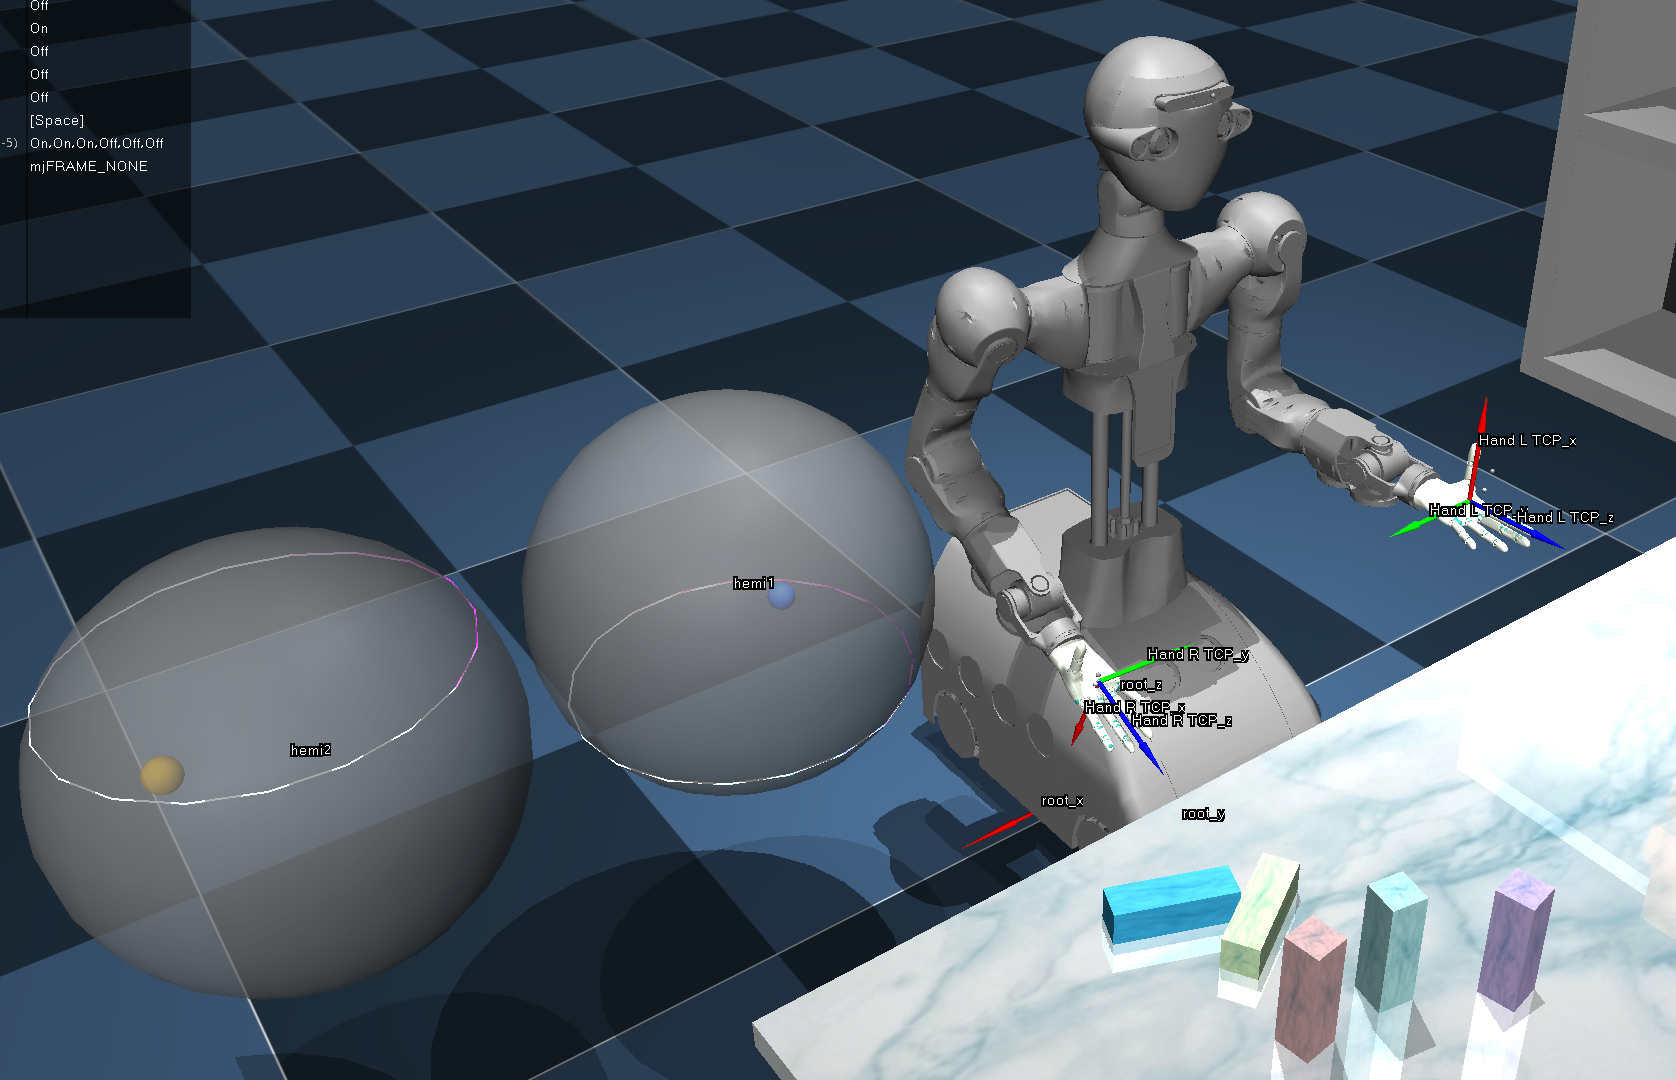
</div>


In [14]:
%%ignore_system_exit

run_zero_torque()

### 2) Quaternion Multiplication

Implementation of Hamilton Product.

In [15]:
def quaternion_multiply(quat1: np.ndarray, quat2: np.ndarray) -> np.ndarray:
    """
    Args:
        quat1: (4, ) or (n, 4)
        quat2: (4, ) or (n, 4)

    Returns: Hamilton product of two quaternions

    """
    w1, x1, y1, z1 = np.split(quat1, 4, axis=-1)
    w2, x2, y2, z2 = np.split(quat2, 4, axis=-1)
    return np.concatenate([
        -x1*x2 - y1*y2 - z1*z2 + w1*w2,
        x1*w2 + y1*z2 - z1*y2 + w1*x2,
        -x1*z2 + y1*w2 + z1*x2 + w1*y2,
        x1*y2 - y1*x2 + z1*w2 + w1*z2
    ], axis=-1)

In [16]:
def quaternion_conjugate(quat):
    """
    Return conjugate of quaternion.
    """
    q_scalar, q_vec = np.split(quat, [1, ], axis=-1)
    return np.concatenate((q_scalar, -q_vec), axis=-1)

In [17]:
def quaternion_rotate(ori_quat, rot_quat):
    return quaternion_multiply(quaternion_multiply(rot_quat, ori_quat), quaternion_conjugate(rot_quat))

In [18]:
import numpy as np
tcp_pose = np.array(
      [[ 0.005 ,  0.9984, -0.0559, -0.4118],
       [ 0.3675,  0.0502,  0.9287,  0.4249],
       [ 0.93  , -0.0252, -0.3666,  0.7242],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

# Using rotation matrix
point_1_local = np.array([0.2, 0.2, 0.2])
point_1_root = tcp_pose[:3, :3].dot(point_1_local) + tcp_pose[:3, 3]
console.log(f"Rotation matrix: {point_1_root}")

# Using quaternion
v_quat = np.concatenate((np.array([0.]), point_1_local))
tcp_quat = tn.quaternion_from_matrix(tcp_pose)
tn.quaternion_rotate(v_quat, tcp_quat)
console.log(f"Quaternion multiplication: {point_1_root}")

[18:29:59] Rotation matrix: [-0.2223  0.6942  0.8318]                                              ]8;id=912836;file:///tmp/ipykernel_11237/4024907430.py\4024907430.py]8;;\:]8;id=978762;file:///tmp/ipykernel_11237/4024907430.py#11\11]8;;\

           Quaternion multiplication: [-0.2223  0.6942  0.8318]                                    ]8;id=846474;file:///tmp/ipykernel_11237/4024907430.py\4024907430.py]8;;\:]8;id=796852;file:///tmp/ipykernel_11237/4024907430.py#17\17]8;;\

## 3. Interpolation of Quaternions

We can use Quaternion Spherical Linear Interpolation (SLERP) to interpolate between two Quaternions. specifically, 

$$
\begin{align}
\text{Slerp}(\mathbf{q}_0, \mathbf{q}_1: t) &= \mathbf{q}_0(\mathbf{q}_0^{-1}\mathbf{q}_1)^t \\
&= \frac{\sin((1-t)\theta)}{\sin\theta} \mathbf{q}_0 + \frac{\sin(t\theta)}{\sin\theta} \mathbf{q}_1
\end{align}
$$

where $t \in [0, 1]$ is the percentage value, and $\theta$ is the angle between the two vectors represented by the unit quaternions. And 
$\text{Slerp}(\mathbf{q}_0, \mathbf{q}_1: t) = \text{Slerp}(\mathbf{q}_1, \mathbf{q}_0: 1-t)$ holds.

In the following example, we visualize interpolated poses between the initial TCP pose and the target TCP pose. The interpolated orientations are computed using SLERP and the positions linear interpolation. We use a task-space impedance controller to let the robot follow such a trajectory and maintain the target pose in the end.

You can also observe the two Quaternion trajectories in the two balls. They are the same trajectory in the double-covered space.

In [19]:
%%ignore_system_exit

run_interpolation_control(xpos_target_l, quat_target_l)

## 4. Understanding the Concatenation of Rotations

<div>
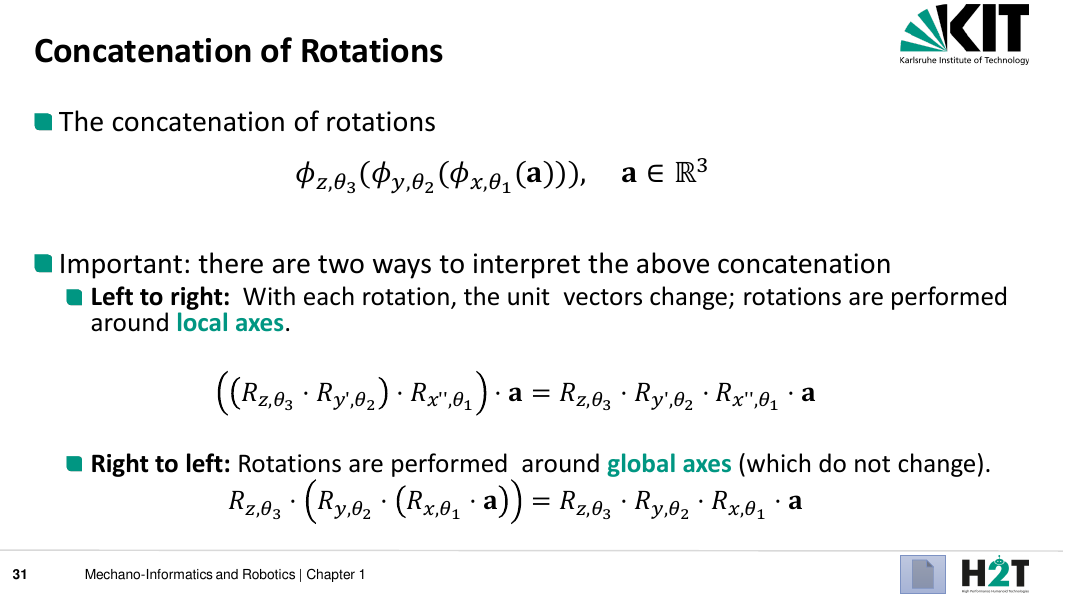
</div>

---

In the following example, we try to rotate the left TCP of ARMAR-6 to a desired pose. 

<div>
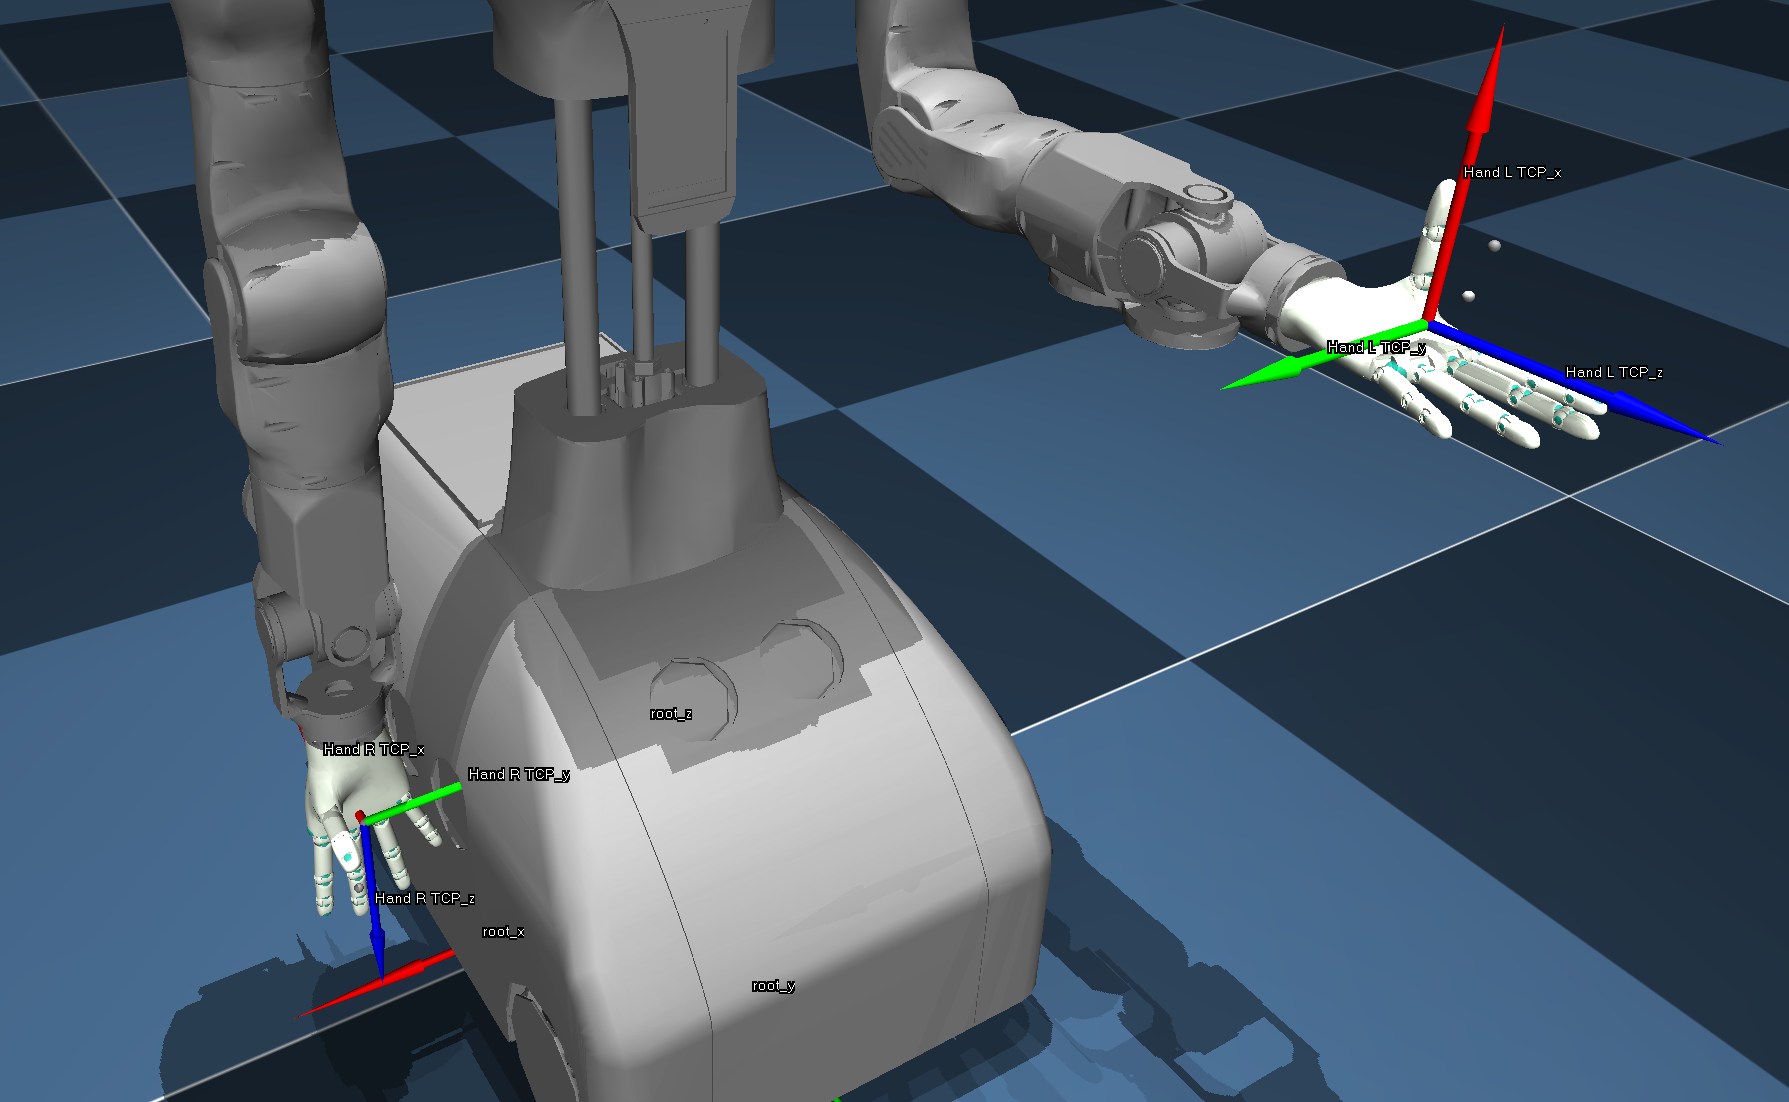
</div>

There are two possibilities to describe the necessary rotation:

1. rotate around the local axes.
2. rotate around the global axes.

Hint: you can press key 1 and 2 to disable the visualization of the table and the robot body respectively.

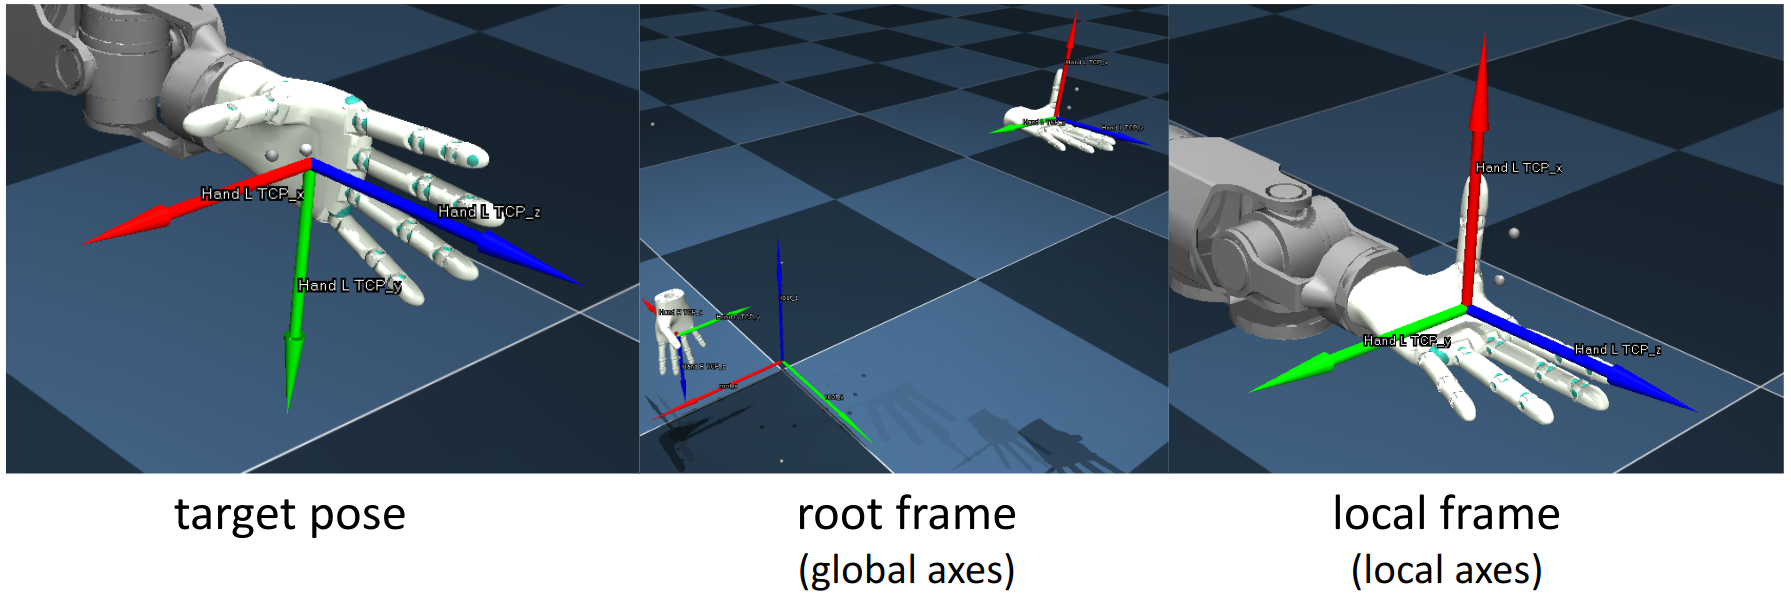

Let's first implement the two ways of rotation.

In [20]:
# rotate around global axes
def rot_func_extrinsic(source_xmat, delta_xmat):
    return delta_xmat.dot(source_xmat)

# rotate around local axes
def rot_func_intrinsic(source_xmat, delta_xmat):
    return source_xmat.dot(delta_xmat)

Now, we rotate around the axis `root_y` of the root frame, i.e., we are rotating around a **global axis**. This results in delta rotation represented in the root frame of the robot. When applying the concatenation of the delta rotation and the TCP orientation, we need to use the **right-to-left** rule. Otherwise, you'll end up in the wrong target pose.

In the viewer, rotate the frame by **keep pressing** keys 8 (rotate counter-clockwise)  or 9 (rotate clockwise). 

See example result:

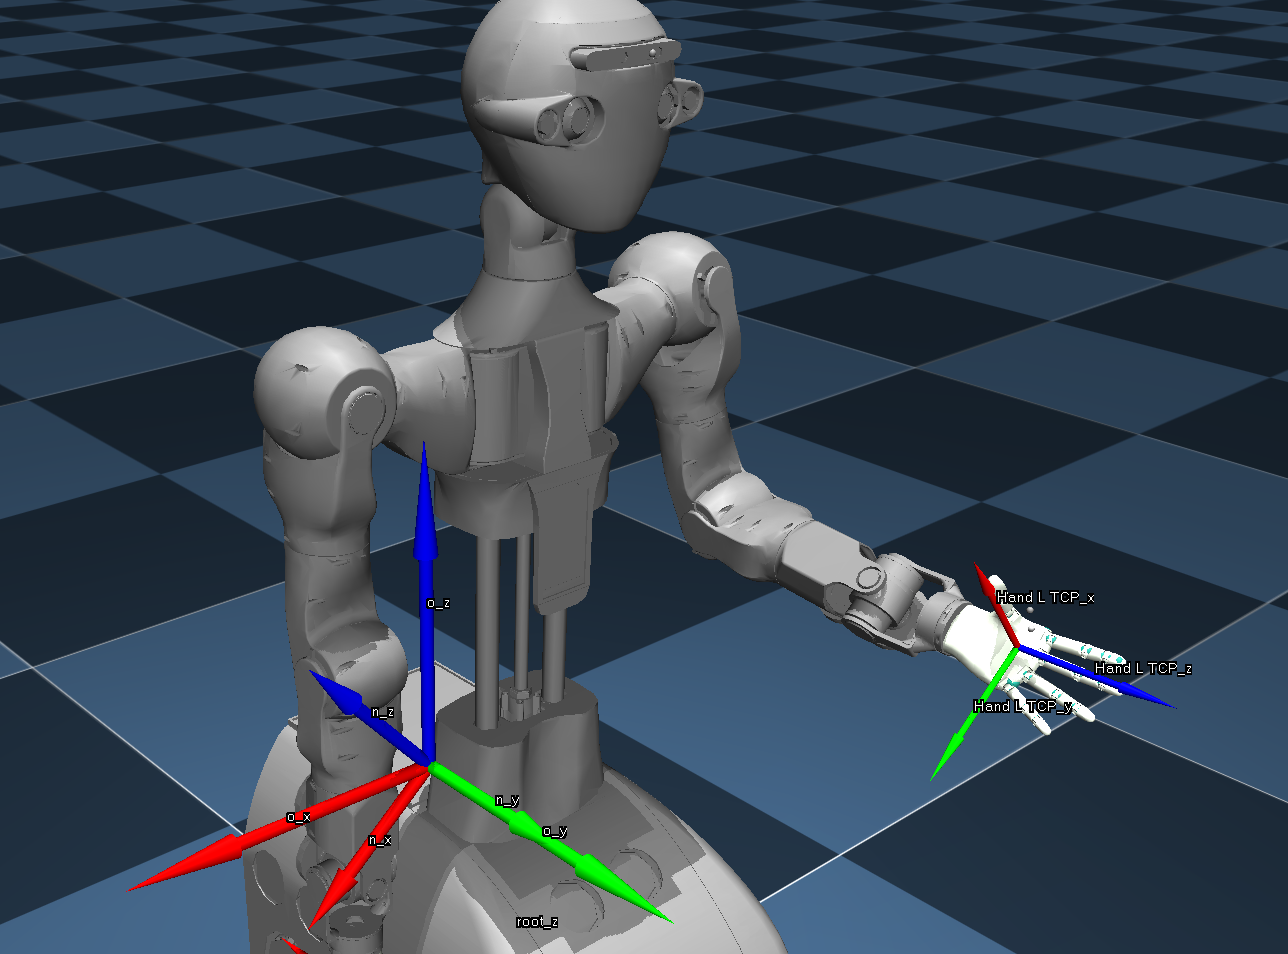

On the left, the frame with longer axes shows the orientation of the `root` frame of the robot (here we consider it the global frame). We press key 8 to rotate the frame which results in a frame with shorter axes. We want to apply the same rotation to the TCP. 

Here, we use the function that implements the rotation around the global axes `root_y`. We observe that the TCP rotates in the same manner as we rotate the global frame.

In [21]:
%%ignore_system_exit

# correct implementation
ex = RotationEx(rot_func_extrinsic, use_intrinsic_rot=False)
ex.run()

In the code below, we replace the function with the one that implements the rotation around the local axes. Then the rotation of the TCP does not corresponds to our expectation anymore.

In [22]:
%%ignore_system_exit

# wrong implementation
ex = RotationEx(rot_func_intrinsic, use_intrinsic_rot=False)
ex.run()

On the other hand, if we rotate around the axis `Hand L TCP_z` of the TCP frame, we are rotating around a **local axis**. Therefore, we need to apply to **left-to-right** rule. We need to use the function for rotating around local axes.

In [23]:
%%ignore_system_exit

# correct implementation
ex = RotationEx(rot_func_intrinsic, use_intrinsic_rot=True)
ex.run()

Again, if we apply the wrong mulplication, the rotation is not as expected anymore.

In [24]:
%%ignore_system_exit

# wrong implementation
ex = RotationEx(rot_func_extrinsic, use_intrinsic_rot=True)
ex.run()

# Further Readings

- Interesting videos of quaternion: [https://youtu.be/d4EgbgTm0Bg?si=OhSJU7jFBA7yOb1h](https://youtu.be/d4EgbgTm0Bg?si=OhSJU7jFBA7yOb1h)
- [Math Magician – Lerp, Slerp, and Nlerp](https://keithmaggio.wordpress.com/2011/02/15/math-magician-lerp-slerp-and-nlerp/)